# Sunoco Gasoline Demand Prediction Script
    Giovanny, Jonathan, Charlotte, and Alexander

## Importing and Cleaning Data

This section will prepare all raw datasets for modeling by converting every source into a consistent weekly time series aligned with the target variable, since all external datasets come in different formats (daily, weekly, monthly, quarterly, annual). The goal of this step is simply to establish a clean, aligned weekly structure for all predictors before moving into full cleaning. 

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
from pandas.tseries.frequencies import to_offset

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
# TARGET - COMPLETE
target = pd.read_csv('target.csv')

# Convert Date column from staring to datetime object
target['Date'] = pd.to_datetime(target['Date'], format='%b %d, %Y')

# Sort by date
target = target.sort_values("Date")

#Extract year compnent to help define the threshold usingo only 2024 data
target["Year"] = target.Date.dt.year

#Compute the 70th percentile of gasoline demand for 2024
#Threshold will define what counts as high demand with 1 and 0
threshold = target.loc[target.Year == 2024, 'U.S. Product Supplied of Finished Motor Gasoline'].quantile(0.7) #
print(threshold)

#Create binary high-demand variable
#1 = demand is >= 70th percentile
#0 = lower demand
target['H_Demand'] = np.where(target['U.S. Product Supplied of Finished Motor Gasoline'] >= threshold, 1, 0)

print(target.H_Demand)
print(target.H_Demand.value_counts(normalize=True))

#Set date as index and dataset restrictions
target = target.set_index('Date')
target = target[['H_Demand']]
target = target.loc['2015-01-01':]
target

9042.8
0       0
1       0
2       0
3       0
4       0
       ..
1789    0
1790    0
1791    1
1792    0
1793    0
Name: H_Demand, Length: 1794, dtype: int32
H_Demand
0    0.656076
1    0.343924
Name: proportion, dtype: float64


,H_Demand
Date,
2015-01-02,0
2015-01-09,0
2015-01-16,0
2015-01-23,0
2015-01-30,0
...,...
2025-02-21,0
2025-02-28,0
2025-03-07,1


In [4]:
#SP500 - COMPLETE
sp500 = pd.read_csv('sp500.csv')
sp500['Date']= pd.to_datetime(sp500['Date'])
sp500 = sp500.set_index('Date')
sp500 = sp500.resample('W-Fri').ffill()

sp500 = sp500.loc['2015-01-01':]

sp500

C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\940333498.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp500['Date']= pd.to_datetime(sp500['Date'])


,S&P 500
Date,
2015-01-02,2058.20
2015-01-09,2044.81
2015-01-16,2019.42
2015-01-23,2051.82
2015-01-30,1994.99
...,...
2025-10-10,6552.51
2025-10-17,6664.01
2025-10-24,6791.69


In [5]:
#JOBLESS CLAIMS - COMPLETE
jobless = pd.read_csv('jobless.csv')
jobless['Date']=pd.to_datetime(jobless['Date'])

jobless = jobless.set_index('Date')
jobless = jobless.loc['2015-01-01':]
jobless.index = jobless.index + to_offset('-1D')

jobless= jobless.resample('W-Fri').ffill()
jobless

,ICSA
Date,
2015-01-02,294000
2015-01-09,304000
2015-01-16,298000
2015-01-23,261000
2015-01-30,281000
...,...
2025-08-22,229000
2025-08-29,236000
2025-09-05,264000


In [6]:
#US Spot Market Prices of Crude Oil - COMPLETE
marketprice_crudeoil = pd.read_csv('marketprice_crudeoil.csv')
marketprice_crudeoil.rename(columns={'Weekly Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'Dollars per Barrel'}, inplace=True)
marketprice_crudeoil

marketprice_crudeoil['Date']= pd.to_datetime(marketprice_crudeoil['Date'])
marketprice_crudeoil = marketprice_crudeoil.set_index('Date')
marketprice_crudeoil = marketprice_crudeoil.resample('W-Fri').ffill()

marketprice_crudeoil = marketprice_crudeoil.loc['2015-01-01':]
marketprice_crudeoil

,Dollars per Barrel
Date,
2015-01-02,53.44
2015-01-09,48.77
2015-01-16,47.07
2015-01-23,46.46
2015-01-30,45.32
...,...
2025-10-03,62.59
2025-10-10,62.10
2025-10-17,58.80


In [7]:
#Europe Spot Market Prices of Crude Oil - COMPLETE
europe = pd.read_csv('Europe Spot Market Prices Crude Oil.csv')
europe['Date'] = pd.to_datetime(europe['Date'], format='%b %d, %Y')
europe = europe.set_index('Date')
europe = europe.resample('W-Fri').ffill()

europe = europe.loc['2015-01-01':]
europe

,Weekly Europe Brent Spot Price FOB (Dollars per Barrel)
Date,
2015-01-02,56.03
2015-01-09,49.47
2015-01-16,46.58
2015-01-23,46.44
2015-01-30,46.76
...,...
2025-10-03,67.15
2025-10-10,66.65
2025-10-17,62.36


In [8]:
#Regular (87 Octane) Gasoline Prices - COMPLETE
gasPrices = pd.read_csv('gasPrices.csv')

gasPrices['Date']=pd.to_datetime(gasPrices['Date'])
gasPrices = gasPrices.set_index('Date')
gasPrices = gasPrices.resample('W-Fri').ffill()


gasPrices = gasPrices['2015-01-01':]


gasPrices

,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)
Date,
2015-01-02,2.299
2015-01-09,2.214
2015-01-16,2.139
2015-01-23,2.066
2015-01-30,2.044
...,...
2025-10-10,3.124
2025-10-17,3.061
2025-10-24,3.019


In [9]:
#USA GDP - COMPLETE
usagdp = pd.read_csv('usagdp.csv')
usagdp['Date']=pd.to_datetime(usagdp['Date'])
usagdp = usagdp.set_index('Date')
usagdp = usagdp.resample('W-Fri').ffill()

usagdp = usagdp.loc['2015-01-01':]

usagdp

,GDP
Date,
2015-01-02,18063.529
2015-01-09,18063.529
2015-01-16,18063.529
2015-01-23,18063.529
2015-01-30,18063.529
...,...
2025-03-07,30042.113
2025-03-14,30042.113
2025-03-21,30042.113


In [10]:
# #Public Transport - COMPLETE
# publicTransport = pd.read_csv('publicTransport.csv')
# publicTransport = publicTransport.drop(135)
# publicTransport['Total Ridership (000s)'] = publicTransport['Total Ridership (000s)'].replace(',', '', regex=True).astype(float)
# publicTransport

# qtm = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'} #mapping Qs to corresponding months of the year
# publicTransport['DateStr'] = publicTransport['Year'].astype(int).astype(str) + '-' + publicTransport['Quarter'].map(qtm) + '-' + '01' #building string of yyyy-mm-01

# publicTransport['DateStr']=\
# publicTransport.DateStr.apply(lambda x: datetime.strptime(x,'%Y-%m-%d') if x != None else x)
# publicTransport['Date'] = pd.to_datetime(publicTransport['DateStr']).dt.to_period('W') #strip date and set to weekly

# def divideWeeks12(value): #12 weeks in a quarter
#     return value / 12

# publicTransport = publicTransport.set_index('Date')

# publicTransport = publicTransport.resample('W').asfreq()

# publicTransport = publicTransport.drop(columns=['Quarter', 'Year - Q', 'Year', 'Heavy Rail (000s)', 'Light Rail (000s)', 'Commuter Rail (000s)', 'Trolleybus (000s)', 'Bus (000s)', 'Demand Response (000s)', 'Other (000s)','DateStr'])
# publicTransport['Total Ridership (000s)'] = publicTransport['Total Ridership (000s)'].apply(divideWeeks12)#applying function to divide value by 12 and forward fill

# publicTransport.index = publicTransport.index.start_time #taking first week value (date column looks like xx-xx-xx/xx-xx-xx before running this line)

# publicTransport.index = publicTransport.index + to_offset('4D')

# #alternate way by using shift variable to achieve 4 day offset of data
# '''
# start_date = pd.to_datetime('1990-11-09') #setting first date from target variable set
# current_start_date = publicTransport['Date'].iloc[44] #finding corresponding week on public transport set to find the time shift
# shift = start_date - current_start_date
# print(shift)
# publicTransport['Date'] = publicTransport['Date'] + shift #applying shift to data so it aligns with target variable
# '''

# publicTransport = publicTransport.iloc[44:]

# publicTransport = publicTransport.resample('W-Fri').ffill()

# publicTransport

In [11]:
#U.S. Crude Oil and Natural Gas Rotary Rigs in Operation - COMPLETE
crude_oil = pd.read_csv("U.S._Crude_Oil_and_Natural_Gas_Rotary_Rigs_in_Operation.csv")

crude_oil['Date'] = pd.to_datetime(crude_oil['Date'])
crude_oil = crude_oil.set_index('Date')

crude_oil = crude_oil.resample('W-Fri').ffill()

crude_oil = crude_oil['2015-01-01':]
crude_oil

C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\900395455.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crude_oil['Date'] = pd.to_datetime(crude_oil['Date'])


,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)
Date,
2015-01-02,1651
2015-01-09,1651
2015-01-16,1651
2015-01-23,1651
2015-01-30,1651
...,...
2025-08-08,538
2025-08-15,538
2025-08-22,538


In [12]:
#Automobile Sales - COMPLETE
autoSales = pd.read_csv('automobileSales.csv')

autoSales['DATE'] = pd.to_datetime(autoSales['DATE'])
autoSales = autoSales.set_index('DATE')
autoSales = autoSales.resample('W-Fri').ffill()
autoSales = autoSales['2015-01-01':]

autoSales

,TOTALSALES (Millions of units)
DATE,
2015-01-02,16.910
2015-01-09,16.910
2015-01-16,16.910
2015-01-23,16.910
2015-01-30,16.910
...,...
2025-07-04,16.896
2025-07-11,16.896
2025-07-18,16.896


In [13]:
#Personal Expenditure - COMPLETE
perExp = pd.read_csv('personalExp.csv')

perExp['DATE'] = pd.to_datetime(perExp['DATE'])
perExp = perExp.set_index('DATE')
perExp = perExp.resample('W-Fri').ffill()

# def divideWeeks4(value):
#     return value / 4
# perExp['PCE(Billions of Dollars)'] = perExp['PCE(Billions of Dollars)'].apply(divideWeeks4)

perExp = perExp.loc['2015-01-01':]

perExp

,PCE(Billions of Dollars)
DATE,
2015-01-02,12066.7
2015-01-09,12066.7
2015-01-16,12066.7
2015-01-23,12066.7
2015-01-30,12066.7
...,...
2025-07-04,20982.7
2025-07-11,20982.7
2025-07-18,20982.7


In [14]:
# Consumer Credit - COMPLETE
Consumer_Credit = pd.read_csv('ConsumerCreditData.csv')

Consumer_Credit['observation_date'] = pd.to_datetime(Consumer_Credit['observation_date'])
Consumer_Credit = Consumer_Credit.rename(columns={'observation_date': 'Date'})
Consumer_Credit = Consumer_Credit.set_index('Date')
Consumer_Credit = Consumer_Credit.resample('W-Fri').ffill()

Consumer_Credit = Consumer_Credit.loc['2015-01-01':]

Consumer_Credit

,HCCSDODNS
Date,
2015-01-02,3360.573
2015-01-09,3360.573
2015-01-16,3360.573
2015-01-23,3360.573
2015-01-30,3360.573
...,...
2025-03-07,5022.913
2025-03-14,5022.913
2025-03-21,5022.913


In [15]:
# #EV Sales
# evSales = pd.read_csv('EV_Sales.csv')
# evSales = evSales[['year', 'value']]

# evSales['Date'] = evSales['year'].astype(str) + '-01-01'
# evSales['Date'] = pd.to_datetime(evSales['Date'])
# evSales = evSales.drop(columns=['year'])

# evSales = evSales.set_index('Date')

# evSales = evSales.groupby('Date')['value'].sum().to_frame()

# evSales = evSales.resample('W-Fri').ffill()

# evSales = evSales.loc['2015-01-01':]
# evSales

In [16]:
# # Step 0: Read + rename
# EVregulations = pd.read_csv('EV Regulations.csv')
# EVregulations.rename(columns={'Model Year': 'Date'}, inplace=True)

# # Step 1: Replace "Total" with NA
# EVregulations['Date'] = EVregulations['Date'].replace('Total', pd.NA)

# # Step 2: Convert to numeric safely
# EVregulations['Date'] = pd.to_numeric(EVregulations['Date'], errors='coerce')

# # Step 3: Drop NA years
# EVregulations = EVregulations.dropna(subset=['Date'])

# # Step 4: Make ISO week string with weekday (Monday = 1)
# EVregulations['Date'] = (
#     EVregulations['Date'].astype(int).astype(str) + '-W01-1'
# )

# # Step 5: Convert to datetime (now valid)
# EVregulations['Date'] = pd.to_datetime(
#     EVregulations['Date'], 
#     format='%G-W%V-%u'
# )

# EVregulations = EVregulations.loc['2015-01-01':]
# EVregulations

In [17]:
# Household Debt and Credit - CLEAN (no interpolation)
Household_debt_credit = pd.read_csv('Household Debt and Credit.csv')
Household_debt_credit.rename(columns={'YY:Q#': 'Date'}, inplace=True)

# Split YY:Q# into Year and Quarter
Household_debt_credit[['Year', 'Quarter']] = Household_debt_credit['Date'].str.split(':Q', expand=True)

# Convert Year + Quarter to a proper datetime
Household_debt_credit['Date'] = (
    Household_debt_credit['Year'] + 'Q' + Household_debt_credit['Quarter']
).pipe(lambda s: pd.PeriodIndex(s, freq='Q').to_timestamp())


Household_debt_credit = Household_debt_credit.set_index('Date')
Household_debt_credit = Household_debt_credit[['Total']]
Household_debt_credit = Household_debt_credit.resample('W-Fri').ffill()
Household_debt_credit = Household_debt_credit.loc['2015-01-01':]

Household_debt_credit

,Total
Date,
2015-01-02,11.850
2015-01-09,11.850
2015-01-16,11.850
2015-01-23,11.850
2015-01-30,11.850
...,...
2025-06-06,18.388
2025-06-13,18.388
2025-06-20,18.388


In [18]:
#Labor Costs - COMPLETE
Labor_Costs = pd.read_csv('Labor Costs.csv')
Labor_Costs = Labor_Costs.rename(columns={'Month ': 'Date'})
Labor_Costs['Date'] = pd.to_datetime(Labor_Costs['Date'])
Labor_Costs = Labor_Costs.set_index('Date')
Labor_Costs = Labor_Costs.resample('W-FRI').ffill()

Labor_Costs = Labor_Costs.drop('Government', axis='columns')
Labor_Costs['Private Industry'] = Labor_Costs['Private Industry'].str.replace('%', '', regex=False)
Labor_Costs['Private Industry'] = pd.to_numeric(Labor_Costs['Private Industry'], errors='coerce')

Labor_Costs = Labor_Costs.loc['2015-01-01':]
Labor_Costs

,Private Industry
Date,
2015-01-02,0.6
2015-01-09,0.6
2015-01-16,0.6
2015-01-23,0.6
2015-01-30,0.6
...,...
2025-05-09,0.8
2025-05-16,0.8
2025-05-23,0.8


In [19]:
#US Refinery- COMPLETE
us_refinery = pd.read_csv("U.S. Refinery Utilization and Capacity.csv", header=None)

us_refinery.columns = us_refinery.iloc[0]
us_refinery = us_refinery.iloc[1:].reset_index(drop=True)

us_refinery['Date'] = pd.to_datetime(us_refinery['Date'])
us_refinery = us_refinery.set_index('Date')

us_refinery = us_refinery.iloc[:,[0]]

us_refinery = us_refinery.resample('W-FRI').ffill()

us_refinery = us_refinery.loc['2015-01-01':]

us_refinery

C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\1633708201.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  us_refinery['Date'] = pd.to_datetime(us_refinery['Date'])


,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)
Date,
2015-01-02,15767
2015-01-09,15767
2015-01-16,15767
2015-01-23,15767
2015-01-30,15767
...,...
2025-07-04,17388
2025-07-11,17388
2025-07-18,17388


In [20]:
#U.S. Dollar Index - COMPLETE
us_dollar = pd.read_csv("US Dollar index 00-23.csv")

us_dollar['Date'] = pd.to_datetime(us_dollar['Date'])
us_dollar = us_dollar.sort_values(by='Date').set_index('Date')

us_dollar = us_dollar[['Close']]
us_dollar['Close'] = pd.to_numeric(us_dollar['Close'])
us_dollar = us_dollar.resample('W-FRI').ffill()

us_dollar = us_dollar.loc['2015-01-01':]
us_dollar

C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\2969682303.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  us_dollar['Date'] = pd.to_datetime(us_dollar['Date'])


,Close
Date,
2015-01-02,94.85
2015-01-09,94.85
2015-01-16,94.85
2015-01-23,94.85
2015-01-30,94.85
...,...
2025-09-05,97.78
2025-09-12,97.78
2025-09-19,97.78


In [21]:
#Housing Market Expectations - Complete
housing_market = pd.read_csv("houseMarket.csv")

housing_market['Date'] = pd.to_datetime(housing_market['Year-Month'], format='%Y-%m')
housing_market = housing_market.drop(columns=['Year-Month'])
housing_market = housing_market.set_index('Date')

housing_market = housing_market.resample('W-Fri').ffill()

housing_market = housing_market.loc['2015-01-01':]

housing_market

,Median expected home price change
Date,
2015-01-02,3.42
2015-01-09,3.42
2015-01-16,3.42
2015-01-23,3.42
2015-01-30,3.42
...,...
2025-09-05,3.00
2025-09-12,3.00
2025-09-19,3.00


In [22]:
#Inflation Expectation - Complete
inflation_expectation = pd.read_csv("Inflation Expectation.csv")

inflation_expectation.rename(columns={'yyddmm': 'Date'}, inplace=True)
inflation_expectation['Date'] = pd.to_datetime(inflation_expectation['Date'].astype(int), format='%Y%m')

inflation_expectation = inflation_expectation.set_index('Date')
inflation_expectation = inflation_expectation[['Median one-year ahead expected inflation rate']]
#inflation_expectation = pd.to_numeric(inflation_expectation['Median one-year ahead expected inflation rate'])

inflation_expectation = inflation_expectation.resample('W-FRI').ffill()

inflation_expectation = inflation_expectation.loc['2015-01-01':]
inflation_expectation

,Median one-year ahead expected inflation rate
Date,
2015-01-02,2.93
2015-01-09,2.93
2015-01-16,2.93
2015-01-23,2.93
2015-01-30,2.93
...,...
2025-09-05,3.38
2025-09-12,3.38
2025-09-19,3.38


In [23]:
#Employer Earnings
empEarnings = pd.read_csv('Employee Earnings.csv')

empEarnings = empEarnings[['Date', 'Mean']]

empEarnings['Date'] = pd.to_datetime(empEarnings['Date'])
empEarnings = empEarnings.set_index('Date')

empEarnings = empEarnings.resample('W-Fri').ffill()
empEarnings = empEarnings.loc['2015-01-01':]

empEarnings

C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\377695591.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  empEarnings['Date'] = pd.to_datetime(empEarnings['Date'])


,Mean
Date,
2015-01-02,58.5
2015-01-09,58.5
2015-01-16,58.5
2015-01-23,58.5
2015-01-30,58.5
...,...
2025-06-06,79.0
2025-06-13,79.0
2025-06-20,79.0


In [24]:
#U.S. Population- COMPLETE

US_pop = pd.read_csv("US Demographic (population).csv")

US_pop= US_pop.drop(columns='Date ')
US_pop = US_pop.drop(columns='Population ')
US_pop = US_pop.rename(columns={'Date .1': 'Date'})
US_pop['Date'] = pd.to_datetime(US_pop['Date'], format='%b %d %Y')
US_pop = US_pop.set_index('Date')


US_pop = US_pop.resample('W-FRI').ffill()
US_pop = US_pop.loc['2015-01-01':]
US_pop

,Popultion (Thousands)
Date,
2015-01-02,320997
2015-01-09,320997
2015-01-16,320997
2015-01-23,320997
2015-01-30,320997
...,...
2025-07-04,342370
2025-07-11,342370
2025-07-18,342370


In [25]:
# Highway Traffic Data- COMPLETE
highway_traffic = pd.read_csv("highway_traffic_data.csv")

highway_traffic.rename(
    columns={
        'Date ': 'Date',
        'Vechiles Miles Travel (Monthly) ': 'Vechiles Miles Travel (Monthly)'
    },
    inplace=True
)

highway_traffic['Date'] = pd.to_datetime(highway_traffic['Date'])
highway_traffic = highway_traffic.set_index('Date')

highway_traffic = highway_traffic.resample('W-FRI').ffill()
highway_traffic = highway_traffic.loc['2015-01-01':]
highway_traffic

C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\354945147.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  highway_traffic['Date'] = pd.to_datetime(highway_traffic['Date'])


,Vechiles Miles Travel (Monthly)
Date,
2015-01-02,233498
2015-01-09,233498
2015-01-16,233498
2015-01-23,233498
2015-01-30,233498
...,...
2025-08-08,294633
2025-08-15,294633
2025-08-22,294633


In [26]:
# #Light Vehicle Sales - COMPlETE
# lightVehicles = pd.read_csv('lightAutos.csv')

# lightVehicles = lightVehicles.rename(columns={'Year': 'Date'})

# lightVehicles['Sales'] = lightVehicles['Sales'].str.replace(',', '', regex=True).astype(float)
# lightVehicles['Date'] = pd.to_datetime(lightVehicles['Date'], format='%Y')
# lightVehicles = lightVehicles.set_index('Date')

# lightVehicles = lightVehicles.resample('W-Fri').ffill()
# lightVehicles = lightVehicles.loc['2015-01-01':]

# lightVehicles

In [27]:
# #Unemployment rate - COMPLETE
# unEmp = pd.read_csv('unempRate.csv')

# unEmp = pd.melt(
#     unEmp,
#     id_vars=['Year'],
#     value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
#     var_name='Month',
#     value_name='Rate'
# )

# unEmp = unEmp.rename(columns={'Year':'Date'})
# unEmp['Date'] = pd.to_datetime(unEmp['Date'], format='%Y')
# unEmp = unEmp.sort_values(by='Date').set_index('Date')

# unEmp = unEmp.drop(columns='Month')
# unEmp = unEmp.resample('W-Fri').ffill()

# # unEmp = unEmp.iloc[2236:3967]

# unEmp

In [28]:
# #Private EV charging stations - COMPLETE
# privEV = pd.read_csv('privEV.csv')

# privEV['EVSE Ports'] = privEV['EVSE Ports'].replace(',', '', regex=True).astype(float)

# # Drop Station locations column
# privEV = privEV.drop(columns=['Station locations'], errors='ignore')

# privEV['Date'] = pd.to_datetime(privEV['Year'], format='%Y')
# privEV = privEV.set_index('Date').drop(columns=['Year'])

# privEV = privEV.resample('W-Fri').ffill()

# privEV = privEV.loc['2015-01-01':]

# privEV

In [29]:
#Surface Temperature Anomaly - COMPLETE
surfacetemp_anomaly = pd.read_csv('surfacetemp_anomaly.csv')

surfacetemp_anomaly['Date'] = pd.to_datetime(surfacetemp_anomaly['Date'])
surfacetemp_anomaly = surfacetemp_anomaly.set_index('Date')

surfacetemp_anomaly = surfacetemp_anomaly.resample('W-Fri').ffill()
surfacetemp_anomaly = surfacetemp_anomaly.loc['2015-01-01':]

surfacetemp_anomaly

C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\3912000178.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  surfacetemp_anomaly['Date'] = pd.to_datetime(surfacetemp_anomaly['Date'])


,Anomaly
Date,
2015-01-02,1.77
2015-01-09,1.77
2015-01-16,1.77
2015-01-23,1.77
2015-01-30,1.77
...,...
2025-07-04,1.69
2025-07-11,1.69
2025-07-18,1.69


In [30]:
#Net Input of Crude to US refineries - COMPLETE
crudeoil_to_refineries = pd.read_csv('crudeoil_to_refineries.csv')

crudeoil_to_refineries['Date'] = pd.to_datetime(crudeoil_to_refineries['Date'])
crudeoil_to_refineries = crudeoil_to_refineries.set_index('Date')

crudeoil_to_refineries = crudeoil_to_refineries.resample('W-Fri').ffill()
crudeoil_to_refineries = crudeoil_to_refineries.loc['2015-01-01':]

crudeoil_to_refineries

C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\2881354761.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crudeoil_to_refineries['Date'] = pd.to_datetime(crudeoil_to_refineries['Date'])


,U.S. Refinery Net Input of Crude Oil (Thousand Barrels)
Date,
2015-01-02,479140
2015-01-09,479140
2015-01-16,479140
2015-01-23,479140
2015-01-30,479140
...,...
2025-07-04,526987
2025-07-11,526987
2025-07-18,526987


In [31]:
# #US sales of heavy trucks - COMPLETE
# heavytruck_sales = pd.read_csv('heavytruck_sales.csv')

# heavytruck_sales['Date'] = pd.to_datetime(heavytruck_sales['Year'], format='%Y')

# heavytruck_sales = heavytruck_sales.set_index('Date')
# heavytruck_sales = heavytruck_sales.drop(columns='Year')
# heavytruck_sales = heavytruck_sales.resample('W-Fri').ffill()

# heavytruck_sales = heavytruck_sales.loc['2015-01-01':]
# heavytruck_sales

In [32]:
# Natural Gas Electric Power Price - COMPLETE
naturalgas_electric_power_price = pd.read_csv('naturalgas_electric_power_price.csv')

naturalgas_electric_power_price['Month'] = pd.to_datetime(naturalgas_electric_power_price['Month'])

naturalgas_electric_power_price = naturalgas_electric_power_price.rename(columns={'Month': 'Date'})
naturalgas_electric_power_price = naturalgas_electric_power_price.set_index('Date')


# Now resample to weekly frequency
naturalgas_electric_power_price = naturalgas_electric_power_price.resample('W-Fri').ffill()
naturalgas_electric_power_price = naturalgas_electric_power_price.loc['2015-01-01':]

naturalgas_electric_power_price

C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\3971488511.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  naturalgas_electric_power_price['Month'] = pd.to_datetime(naturalgas_electric_power_price['Month'])


,Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet
Date,
2015-01-02,3.28
2015-01-09,3.28
2015-01-16,3.28
2015-01-23,3.28
2015-01-30,3.28
...,...
2025-07-04,3.07
2025-07-11,3.07
2025-07-18,3.07


In [33]:
# # Annual US CO2 Emissions - COMPLETE
# # --- Annual US CO2 Emissions - PREP STAGE (no filling) ---
# co2_emissions = pd.read_csv('co2_emissions.csv')

# co2_emissions = co2_emissions.drop(columns='Unnamed: 2')
# co2_emissions = co2_emissions.iloc[:34]
# co2_emissions['Year'] = pd.to_datetime(co2_emissions['Year'], format='%Y')
# co2_emissions = co2_emissions.rename(columns={'Year':'Date'})
# co2_emissions = co2_emissions.set_index('Date')

# co2_emissions = co2_emissions.resample('W-Fri').ffill()
# co2_emissions = co2_emissions.loc['2015-01-01':]

# co2_emissions

In [34]:
target

,H_Demand
Date,
2015-01-02,0
2015-01-09,0
2015-01-16,0
2015-01-23,0
2015-01-30,0
...,...
2025-02-21,0
2025-02-28,0
2025-03-07,1


# Creating joint data frame

In [35]:
import pandas as pd
    #publicTransport, 
    #EVregulations,
    #unEmp,
    #evSales,
    # lightVehicles,
    #heavytruck_sales,
    # privEV,
    #, co2_emissions

dataframes = [
    target,sp500, jobless, marketprice_crudeoil, europe, gasPrices, usagdp, crude_oil, autoSales, perExp, Consumer_Credit, 
    Household_debt_credit, Labor_Costs, us_refinery, us_dollar, housing_market, inflation_expectation, empEarnings, 
    US_pop, highway_traffic, surfacetemp_anomaly, 
    crudeoil_to_refineries,  naturalgas_electric_power_price
]

# Concatenate along columns
sunoco = pd.concat(dataframes, axis=1)

pd.set_option('display.max_columns', None)
sunoco = sunoco[:'2025-03-31']
sunoco

,H_Demand,S&P 500,ICSA,Dollars per Barrel,Weekly Europe Brent Spot Price FOB (Dollars per Barrel),Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon),GDP,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count),TOTALSALES (Millions of units),PCE(Billions of Dollars),HCCSDODNS,Total,Private Industry,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day),Close,Median expected home price change,Median one-year ahead expected inflation rate,Mean,Popultion (Thousands),Vechiles Miles Travel (Monthly),Anomaly,U.S. Refinery Net Input of Crude Oil (Thousand Barrels),Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet
2015-01-02,0.0,2058.20,294000.0,53.44,56.03,2.299,18063.529,1651.0,16.910,12066.7,3360.573,11.850,0.6,15767,94.85,3.42,2.93,58.5,320997.0,233498.0,1.77,479140.0,3.28
2015-01-09,0.0,2044.81,304000.0,48.77,49.47,2.214,18063.529,1651.0,16.910,12066.7,3360.573,11.850,0.6,15767,94.85,3.42,2.93,58.5,320997.0,233498.0,1.77,479140.0,3.28
2015-01-16,0.0,2019.42,298000.0,47.07,46.58,2.139,18063.529,1651.0,16.910,12066.7,3360.573,11.850,0.6,15767,94.85,3.42,2.93,58.5,320997.0,233498.0,1.77,479140.0,3.28
2015-01-23,0.0,2051.82,261000.0,46.46,46.44,2.066,18063.529,1651.0,16.910,12066.7,3360.573,11.850,0.6,15767,94.85,3.42,2.93,58.5,320997.0,233498.0,1.77,479140.0,3.28
2015-01-30,0.0,1994.99,281000.0,45.32,46.76,2.044,18063.529,1651.0,16.910,12066.7,3360.573,11.850,0.6,15767,94.85,3.42,2.93,58.5,320997.0,233498.0,1.77,479140.0,3.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.0,5954.50,224000.0,69.93,74.25,3.125,30042.113,590.0,16.441,20519.8,5022.913,18.203,0.9,15629,107.61,3.28,3.13,81.9,341588.0,237493.0,1.95,430007.0,3.68
2025-03-07,1.0,5770.20,223000.0,67.52,71.93,3.078,30042.113,592.0,18.331,20683.0,5022.913,18.203,0.8,16153,104.21,3.03,3.58,79.0,341729.0,277598.0,2.03,490719.0,3.45
2025-03-14,0.0,5638.94,225000.0,66.95,71.54,3.069,30042.113,592.0,18.331,20683.0,5022.913,18.203,0.8,16153,104.21,3.03,3.58,79.0,341729.0,277598.0,2.03,490719.0,3.45
2025-03-21,0.0,5667.56,225000.0,67.96,72.21,3.058,30042.113,592.0,18.331,20683.0,5022.913,18.203,0.8,16153,104.21,3.03,3.58,79.0,341729.0,277598.0,2.03,490719.0,3.45


In [36]:
print("Data range before lagging:", sunoco.index.min(), "→", sunoco.index.max())
print("Rows by year:", sunoco.index.value_counts())

Data range before lagging: 2015-01-02 00:00:00 → 2025-03-28 00:00:00
Rows by year: 2015-01-02    1
2021-10-01    1
2022-01-07    1
2021-12-31    1
2021-12-24    1
             ..
2018-04-27    1
2018-04-20    1
2018-04-13    1
2018-04-06    1
2025-03-28    1
Name: count, Length: 535, dtype: int64


In [37]:
sunoco.columns

Index(['H_Demand', 'S&P 500', 'ICSA', 'Dollars per Barrel',
       'Weekly Europe Brent Spot Price FOB (Dollars per Barrel)',
       'Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)',
       'GDP',
       'U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)',
       'TOTALSALES (Millions of units)', 'PCE(Billions of Dollars)',
       'HCCSDODNS', 'Total', 'Private Industry',
       'U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)', 'Close',
       'Median expected home price change',
       'Median one-year ahead expected inflation rate', 'Mean',
       'Popultion (Thousands)', 'Vechiles Miles Travel (Monthly)', 'Anomaly',
       'U.S. Refinery Net Input of Crude Oil (Thousand Barrels)',
       'Texas Natural Gas Price Sold to Electric Power Consumers  Dollars per Thousand Cubic Feet'],
      dtype='object')

# Lagging Dataset

In [38]:
lag_sizes = [4, 5, 6]

variables_to_lag = [
    'S&P 500', 'ICSA', 'Dollars per Barrel',
       'Weekly Europe Brent Spot Price FOB (Dollars per Barrel)',
       'Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)',
       'GDP',
       'U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)',
       'TOTALSALES (Millions of units)', 'PCE(Billions of Dollars)',
       'HCCSDODNS', 'Total', 'Private Industry',
       'U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)', 'Close',
       'Median expected home price change',
       'Median one-year ahead expected inflation rate', 'Mean',
       'Popultion (Thousands)', 'Vechiles Miles Travel (Monthly)', 'Anomaly',
       'U.S. Refinery Net Input of Crude Oil (Thousand Barrels)',
       'Texas Natural Gas Price Sold to Electric Power Consumers  Dollars per Thousand Cubic Feet'
]

# Make all lags on full dataset
for var in variables_to_lag:
    for L in lag_sizes:
        sunoco[f"{var}_lag{L}"] = sunoco[var].shift(L)

# List all lagged columns
all_lagged_cols = [f"{var}_lag{L}" for var in variables_to_lag for L in lag_sizes]

# Remove rows with missing lag values
sunoco = sunoco.dropna(subset=all_lagged_cols)


In [39]:
print("Data range after lagging:", sunoco.index.min(), "→", sunoco.index.max())
print("Rows by year:", sunoco.index.value_counts())

Data range after lagging: 2015-02-13 00:00:00 → 2025-03-28 00:00:00
Rows by year: 2015-02-13    1
2021-10-15    1
2022-01-21    1
2022-01-14    1
2022-01-07    1
             ..
2018-05-25    1
2018-05-18    1
2018-05-11    1
2018-05-04    1
2025-03-28    1
Name: count, Length: 529, dtype: int64


In [40]:
train = sunoco.loc[:'2024-03-31'].copy()
test  = sunoco.loc['2024-04-01':'2025-03-31'].copy()

In [41]:
print(train.shape, test.shape)

(477, 89) (52, 89)


# Cleaning Train and Test

In [42]:
# --- Fill strategy lists ---
# We're defining which columns should be filled by interpolation vs forward/backward filling
interpolate_cols = [
    'H_Demand', 'S&P 500', 'ICSA',
    'Dollars per Barrel', 'Weekly Europe Brent Spot Price FOB (Dollars per Barrel)',
    'Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)',
    'Total Median expected home price change', 'Median one-year ahead expected inflation rate',
    'HCCSDODNS', 'Private Industry', 'Private Industry_lag8', 'Mean',
    'Annual Vehicle-Distance\nTraveled (Billion Miles)', 'Total', 'Total_lag4',
    'Sales', 'Sales (1000s)', 'Rate',
    'U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)',
    'U.S. Refinery Net Input of Crude Oil (Thousand Barrels)',
    'Texas natural gas price for electric power consumers: $/MCF',
    'Vechiles Miles Travel (Monthly)'
]
# 'Annual CO2‚ emissions',
ffill_cols = [
    'Numbers', 'GDP', 'Total Ridership (000s)',
    'U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)',
    'Alternative Fuel Provider', 'EVSE Ports',
    'Popultion (Thousands)', 'Smokers (in millions)'
]

# --- Apply cleaning to TRAIN ---
# --- we're applying cleaning to TRAIN set (fit only on the training period) 
for col in interpolate_cols:
    if col in train.columns:
        # Use linear interpolation through time for smoother economic / time-series variables
        train[col] = train[col].interpolate(method='linear', limit_direction='both')

for col in ffill_cols:
    if col in train.columns:
        # For level-type series, we carried the last observed value forward/backward
        train[col] = train[col].ffill().bfill()

# --- Apply cleaning to TEST (separately!) ---
# --- we're apply the SAME logic to TEST, but separately (no leakage) ---
for col in interpolate_cols:
    if col in test.columns:
        test[col] = test[col].interpolate(method='linear', limit_direction='both')

for col in ffill_cols:
    if col in test.columns:
        test[col] = test[col].ffill().bfill()

# --- We're making sure the date ranges and null counts look reasonable
print("Train range:", train.index.min(), "→", train.index.max())
print("Test range :", test.index.min(), "→", test.index.max())
print("Remaining nulls (train):", train.isna().sum().sum())
print("Remaining nulls (test) :", test.isna().sum().sum())


Train range: 2015-02-13 00:00:00 → 2024-03-29 00:00:00
Test range : 2024-04-05 00:00:00 → 2025-03-28 00:00:00
Remaining nulls (train): 0
Remaining nulls (test) : 0


C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\1329718687.py:29: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train[col] = train[col].interpolate(method='linear', limit_direction='both')
C:\Users\alexp\AppData\Local\Temp\ipykernel_18720\1329718687.py:40: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test[col] = test[col].interpolate(method='linear', limit_direction='both')


In [43]:
# Looking at how many nulls are left per column in TRAIN and TEST
print("Remaining nulls per variable — TRAIN:")
print(train.isna().sum().sort_values(ascending=False))

print("Remaining nulls per variable — TEST:")
print(test.isna().sum().sort_values(ascending=False))


Remaining nulls per variable — TRAIN:
H_Demand                                                                                          0
TOTALSALES (Millions of units)_lag5                                                               0
Median expected home price change_lag4                                                            0
Close_lag6                                                                                        0
Close_lag5                                                                                        0
                                                                                                 ..
ICSA_lag6                                                                                         0
ICSA_lag5                                                                                         0
ICSA_lag4                                                                                         0
S&P 500_lag6                                                  

In [44]:

fill_methods = {
    # Smooth long-term series
    #'value': 'linear',
    'Median expected home price change': 'linear',
    'TOTALSALES (Millions of units)': 'linear',
    'PCE(Billions of Dollars)': 'linear',
    'Anomaly': 'linear',
    'Close': 'linear'
}

for col, method in fill_methods.items():
    if method == 'linear':
        train[col] = train[col].interpolate(method='linear', limit_direction='both')
        test[col] = test[col].interpolate(method='linear', limit_direction='both')


In [45]:
# Re-checking nulls after the second round of filling
print("Remaining nulls per variable — TRAIN:")
print(train.isna().sum().sort_values(ascending=False))

print("\nRemaining nulls per variable — TEST:")
print(test.isna().sum().sort_values(ascending=False))

Remaining nulls per variable — TRAIN:
H_Demand                                                                                          0
TOTALSALES (Millions of units)_lag5                                                               0
Median expected home price change_lag4                                                            0
Close_lag6                                                                                        0
Close_lag5                                                                                        0
                                                                                                 ..
ICSA_lag6                                                                                         0
ICSA_lag5                                                                                         0
ICSA_lag4                                                                                         0
S&P 500_lag6                                                  

In [46]:
print(test.shape, train.shape)

(52, 89) (477, 89)


In [47]:
test = test.sort_index()

In [48]:
test = test.sort_index()
print("Data range after lagging:", test.index.min(), "→", test.index.max())
print("Rows by year:", test.index.value_counts())
test

Data range after lagging: 2024-04-05 00:00:00 → 2025-03-28 00:00:00
Rows by year: 2024-04-05    1
2024-04-12    1
2024-10-18    1
2024-10-25    1
2024-11-01    1
2024-11-08    1
2024-11-15    1
2024-11-22    1
2024-11-29    1
2024-12-06    1
2024-12-13    1
2024-12-20    1
2024-12-27    1
2025-01-03    1
2025-01-10    1
2025-01-17    1
2025-01-24    1
2025-01-31    1
2025-02-07    1
2025-02-14    1
2025-02-21    1
2025-02-28    1
2025-03-07    1
2025-03-14    1
2025-03-21    1
2024-10-11    1
2024-10-04    1
2024-09-27    1
2024-06-28    1
2024-04-19    1
2024-04-26    1
2024-05-03    1
2024-05-10    1
2024-05-17    1
2024-05-24    1
2024-05-31    1
2024-06-07    1
2024-06-14    1
2024-06-21    1
2024-07-05    1
2024-09-20    1
2024-07-12    1
2024-07-19    1
2024-07-26    1
2024-08-02    1
2024-08-09    1
2024-08-16    1
2024-08-23    1
2024-08-30    1
2024-09-06    1
2024-09-13    1
2025-03-28    1
Name: count, dtype: int64


,H_Demand,S&P 500,ICSA,Dollars per Barrel,Weekly Europe Brent Spot Price FOB (Dollars per Barrel),Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon),GDP,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count),TOTALSALES (Millions of units),PCE(Billions of Dollars),HCCSDODNS,Total,Private Industry,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day),Close,Median expected home price change,Median one-year ahead expected inflation rate,Mean,Popultion (Thousands),Vechiles Miles Travel (Monthly),Anomaly,U.S. Refinery Net Input of Crude Oil (Thousand Barrels),Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet,S&P 500_lag4,S&P 500_lag5,S&P 500_lag6,ICSA_lag4,ICSA_lag5,ICSA_lag6,Dollars per Barrel_lag4,Dollars per Barrel_lag5,Dollars per Barrel_lag6,Weekly Europe Brent Spot Price FOB (Dollars per Barrel)_lag4,Weekly Europe Brent Spot Price FOB (Dollars per Barrel)_lag5,Weekly Europe Brent Spot Price FOB (Dollars per Barrel)_lag6,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)_lag4,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)_lag5,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)_lag6,GDP_lag4,GDP_lag5,GDP_lag6,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)_lag4,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)_lag5,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)_lag6,TOTALSALES (Millions of units)_lag4,TOTALSALES (Millions of units)_lag5,TOTALSALES (Millions of units)_lag6,PCE(Billions of Dollars)_lag4,PCE(Billions of Dollars)_lag5,PCE(Billions of Dollars)_lag6,HCCSDODNS_lag4,HCCSDODNS_lag5,HCCSDODNS_lag6,Total_lag4,Total_lag5,Total_lag6,Private Industry_lag4,Private Industry_lag5,Private Industry_lag6,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)_lag4,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)_lag5,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)_lag6,Close_lag4,Close_lag5,Close_lag6,Median expected home price change_lag4,Median expected home price change_lag5,Median expected home price change_lag6,Median one-year ahead expected inflation rate_lag4,Median one-year ahead expected inflation rate_lag5,Median one-year ahead expected inflation rate_lag6,Mean_lag4,Mean_lag5,Mean_lag6,Popultion (Thousands)_lag4,Popultion (Thousands)_lag5,Popultion (Thousands)_lag6,Vechiles Miles Travel (Monthly)_lag4,Vechiles Miles Travel (Monthly)_lag5,Vechiles Miles Travel (Monthly)_lag6,Anomaly_lag4,Anomaly_lag5,Anomaly_lag6,U.S. Refinery Net Input of Crude Oil (Thousand Barrels)_lag4,U.S. Refinery Net Input of Crude Oil (Thousand Barrels)_lag5,U.S. Refinery Net Input of Crude Oil (Thousand Barrels)_lag6,Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet_lag4,Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet_lag5,Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet_lag6
2024-04-05,0.0,5204.34,212000.0,86.35,90.34,3.517,29147.044,617.0,16.442,19665.7,5027.251,17.796,1.0,16395,106.22,3.29,3.26,83.6,339648.0,273208.0,2.47,476453.0,1.49,5123.69,5137.08,5088.80,213000.0,212000.0,214000.0,79.53,79.58,78.71,85.63,84.26,85.02,3.350,3.249,3.269,28708.161,28708.161,28708.161,625.0,625.0,622.0,16.217,16.217,16.262,19581.8,19581.8,19446.5,5013.917,5013.917,5013.917,17.687,17.687,17.687,1.0,1.0,0.9,16258,16258,15205,104.55,104.55,104.16,3.05,3.05,3.00,3.00,3.00,3.04,83.6,83.6,79.0,339378.0,339378.0,339114.0,274585.0,274585.0,241014.0,2.52,2.52,2.79,491803.0,491803.0,431574.0,1.57,1.57,1.95
2024-04-12,0.0,5123.41,211000.0,86.50,92.01,3.591,29147.044,617.0,16.442,19665.7,5027.251,17.796,1.0,16395,106.22,3.29,3.26,83.6,339648.0,273208.0,2.47,476453.0,1.49,5117.09,5123.69,5137.08,213000.0,213000.0,212000.0,80.43,79.53,79.58,84.52,85.63,84.26,3.376,3.350,3.249,28708.161,28708.161,28708.161,625.0,62

In [49]:
print(train.shape,test.shape)

(477, 89) (52, 89)


In [50]:
# all_lagged_cols = [f"{var}_lag{L}" for var in variables_to_lag for L in lag]
# train = train.dropna(subset=all_lagged_cols)
# test = test.dropna(subset=all_lagged_cols)

In [51]:
#remove all missing values form the dataset
train_na = train.notna().all(axis=1)
train = train.loc[train_na].reset_index(drop=True)
test_na = test.notna().all(axis=1)
test = test.loc[test_na].reset_index(drop=True)

# XGBoost

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


# We split predictors and target again from the reduced datasets
X_train = train.drop(columns=['H_Demand']).copy()
y_train = train['H_Demand'].copy()
X_test  = test.drop(columns=['H_Demand']).copy()
y_test  = test['H_Demand'].copy()

# # These are the final matrices We're going to feed into the models later
# train_final = pd.concat([y_train, X_train], axis=1)
# test_final  = pd.concat([y_test,  X_test],  axis=1)


In [53]:
train

,H_Demand,S&P 500,ICSA,Dollars per Barrel,Weekly Europe Brent Spot Price FOB (Dollars per Barrel),Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon),GDP,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count),TOTALSALES (Millions of units),PCE(Billions of Dollars),HCCSDODNS,Total,Private Industry,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day),Close,Median expected home price change,Median one-year ahead expected inflation rate,Mean,Popultion (Thousands),Vechiles Miles Travel (Monthly),Anomaly,U.S. Refinery Net Input of Crude Oil (Thousand Barrels),Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet,S&P 500_lag4,S&P 500_lag5,S&P 500_lag6,ICSA_lag4,ICSA_lag5,ICSA_lag6,Dollars per Barrel_lag4,Dollars per Barrel_lag5,Dollars per Barrel_lag6,Weekly Europe Brent Spot Price FOB (Dollars per Barrel)_lag4,Weekly Europe Brent Spot Price FOB (Dollars per Barrel)_lag5,Weekly Europe Brent Spot Price FOB (Dollars per Barrel)_lag6,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)_lag4,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)_lag5,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)_lag6,GDP_lag4,GDP_lag5,GDP_lag6,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)_lag4,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)_lag5,U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)_lag6,TOTALSALES (Millions of units)_lag4,TOTALSALES (Millions of units)_lag5,TOTALSALES (Millions of units)_lag6,PCE(Billions of Dollars)_lag4,PCE(Billions of Dollars)_lag5,PCE(Billions of Dollars)_lag6,HCCSDODNS_lag4,HCCSDODNS_lag5,HCCSDODNS_lag6,Total_lag4,Total_lag5,Total_lag6,Private Industry_lag4,Private Industry_lag5,Private Industry_lag6,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)_lag4,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)_lag5,U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)_lag6,Close_lag4,Close_lag5,Close_lag6,Median expected home price change_lag4,Median expected home price change_lag5,Median expected home price change_lag6,Median one-year ahead expected inflation rate_lag4,Median one-year ahead expected inflation rate_lag5,Median one-year ahead expected inflation rate_lag6,Mean_lag4,Mean_lag5,Mean_lag6,Popultion (Thousands)_lag4,Popultion (Thousands)_lag5,Popultion (Thousands)_lag6,Vechiles Miles Travel (Monthly)_lag4,Vechiles Miles Travel (Monthly)_lag5,Vechiles Miles Travel (Monthly)_lag6,Anomaly_lag4,Anomaly_lag5,Anomaly_lag6,U.S. Refinery Net Input of Crude Oil (Thousand Barrels)_lag4,U.S. Refinery Net Input of Crude Oil (Thousand Barrels)_lag5,U.S. Refinery Net Input of Crude Oil (Thousand Barrels)_lag6,Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet_lag4,Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet_lag5,Texas Natural Gas Price Sold to Electric Power Consumers Dollars per Thousand Cubic Feet_lag6
0,0.0,2096.99,285000.0,51.14,56.57,2.191,18063.529,1348.0,16.891,12116.6,3360.573,11.850,0.6,15635,95.25,3.00,2.83,58.5,321164.0,217220.0,0.77,429564.0,3.10,2019.42,2044.81,2058.20,298000.0,304000.0,294000.0,47.07,48.77,53.44,46.58,49.47,56.03,2.139,2.214,2.299,18063.529,18063.529,18063.529,1651.0,1651.0,1651.0,16.910,16.910,16.910,12066.7,12066.7,12066.7,3360.573,3360.573,3360.573,11.850,11.850,11.850,0.6,0.6,0.6,15767,15767,15767,94.85,94.85,94.85,3.42,3.42,3.42,2.93,2.93,2.93,58.5,58.5,58.5,320997.0,320997.0,320997.0,233498.0,233498.0,233498.0,1.77,1.77,1.77,479140.0,479140.0,479140.0,3.28,3.28,3.28
1,0.0,2110.30,305000.0,51.69,60.57,2.274,18063.529,1348.0,16.891,12116.6,3360.573,11.850,0.6,15635,95.25,3.00,2.83,58.5,321164.0,217220.0,0.77,429564.0,3.10,2051.82,2019.42,2044.81,261000.0,298000.0,304000.0,46.46,47.07,48.77,46.44,46.58,49.47,2.066,2.139,2.214,18063.529,18063.529,18063.529,1651.0,1651.0,1651.0,16.91

In [54]:
#Dropping all non numeric columns 
non_numeric = X_train.select_dtypes(exclude=['number','bool']).columns
print("dropped cols", list(non_numeric))

dropped cols ['U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)', 'U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)_lag4', 'U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)_lag5', 'U.S. Gross Inputs to Refineries (Thousand Barrels Per Day)_lag6']


In [55]:
X_train_xgb = X_train.drop(columns=non_numeric)
X_test_xgb = X_test.drop(columns=non_numeric)

In [56]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [58]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# From scikit-learn packages.
from sklearn.datasets import make_classification # To generate our sample classification dataset.
from sklearn.model_selection import train_test_split, GridSearchCV # To split data and tune our model.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc # For evaluating our model's performance.

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [59]:


TP_cost = -1
TN_cost = 0
FN_cost = 2
FP_cost = 1
cost_ratio = FN_cost / FP_cost

# Define the weight dictionary for Keras
#class_weights_nn = {0: 1.0, 1: cost_ratio}

print(f"\n--- Model Training will be Cost-Aware ---")
print(f"Cost Ratio (FN_cost / FP_cost): {cost_ratio}")
# print(f"XGB/CatBoost will use `scale_pos_weight` = {cost_ratio}")
# print(f"Keras NN will use `class_weight` = {class_weights_nn}")

# --- STEP 7: XGBOOST MODELING WITH HYPERPARAMETER TUNING ---
# We will use GridSearchCV to find the best combination of other hyperparameters.
# Our `scale_pos_weight` will be fixed for all combinations.

param_grid_xgb = {
    'n_estimators': [200, 300], 
    'learning_rate': [0.05, 0.1], 
    'gamma': [0, 0.6],
    'max_depth': [3, 5], #3,5
    "subsample": [0.6,0.8],
    "colsample_bytree":[0.6,0.8]
}

# Initialize the XGBoost CLASSIFIER model.
xgbc = xgb.XGBClassifier(objective='binary:logistic',
                           use_label_encoder=False,
                           eval_metric='aucpr',
                           random_state=42,
                           scale_pos_weight=0.3 # If this doesn't work, try higher numbers
                          )

time_series_cv = TimeSeriesSplit(n_splits=3)

# Set up GridSearchCV. The scoring metric 'roc_auc' is good for imbalanced data.
grid_search_xgb = GridSearchCV(estimator=xgbc,
                               param_grid=param_grid_xgb,
                               cv=time_series_cv ,
                               scoring='roc_auc',
                               verbose=1,
                               n_jobs=-1)

print("\n--- Starting XGBoost Hyperparameter Tuning ---")
# Use the *encoded* but *unscaled* data
grid_search_xgb.fit(X_train_xgb, y_train)


print("\n--- XGBoost Tuning Complete ---")
print("Best hyperparameters found for XGBoost:")
print(grid_search_xgb.best_params_)

best_model_xgb = grid_search_xgb.best_estimator_



--- Model Training will be Cost-Aware ---
Cost Ratio (FN_cost / FP_cost): 2.0

--- Starting XGBoost Hyperparameter Tuning ---
Fitting 3 folds for each of 64 candidates, totalling 192 fits


c:\Users\alexp\anaconda3new\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:20:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Tuning Complete ---
Best hyperparameters found for XGBoost:
{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [60]:
#Accuracy
y_pred = best_model_xgb.predict(X_test_xgb)
accuracy = accuracy_score(y_test, y_pred)

print("\n--- XGBoost Performance on Test Set (Default 0.5 Threshold) ---")
print(f"Accuracy: {accuracy:.2f}")


--- XGBoost Performance on Test Set (Default 0.5 Threshold) ---
Accuracy: 0.71


In [61]:

print("\n--- Classification Report (Default 0.5 Threshold) ---")
print(classification_report(y_test, y_pred))


--- Classification Report (Default 0.5 Threshold) ---
              precision    recall  f1-score   support

         0.0       0.74      0.92      0.82        37
         1.0       0.50      0.20      0.29        15

    accuracy                           0.71        52
   macro avg       0.62      0.56      0.55        52
weighted avg       0.67      0.71      0.67        52




--- Visualizing XGBoost Performance (Default 0.5 Threshold) ---


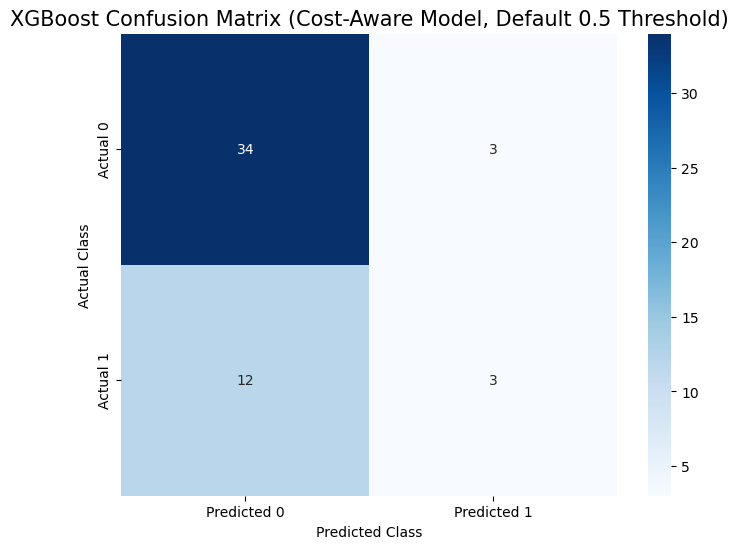

In [62]:
# Visualization 1: Confusion Matrix (Default 0.5 Threshold)
print("\n--- Visualizing XGBoost Performance (Default 0.5 Threshold) ---")
cm_default_xgb = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_default_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('XGBoost Confusion Matrix (Cost-Aware Model, Default 0.5 Threshold)', fontsize=15)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

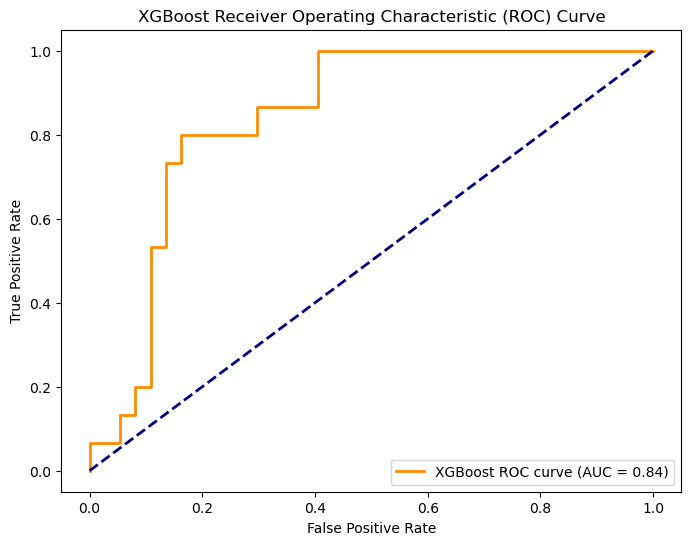

In [63]:
# Visualization 2: ROC Curve and AUC Score
# This plot shows the model's overall discriminatory power.
y_pred_proba = best_model_xgb.predict_proba(X_test_xgb)[:, 1] # Get probabilities for class 1
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()



--- Finding Optimal Threshold for XGBoost ---
Cost of False Positive (FP): 1
Cost of False Negative (FN): 2
Cost of True Positive (TP): 0
Cost of True Negative (TN): 0

XGBoost Optimal Threshold: 0.31
XGBoost Minimum Total Cost: 13 (for all 52 test observations)
XGBoost Minimum Mean Cost Per Observation: 0.25


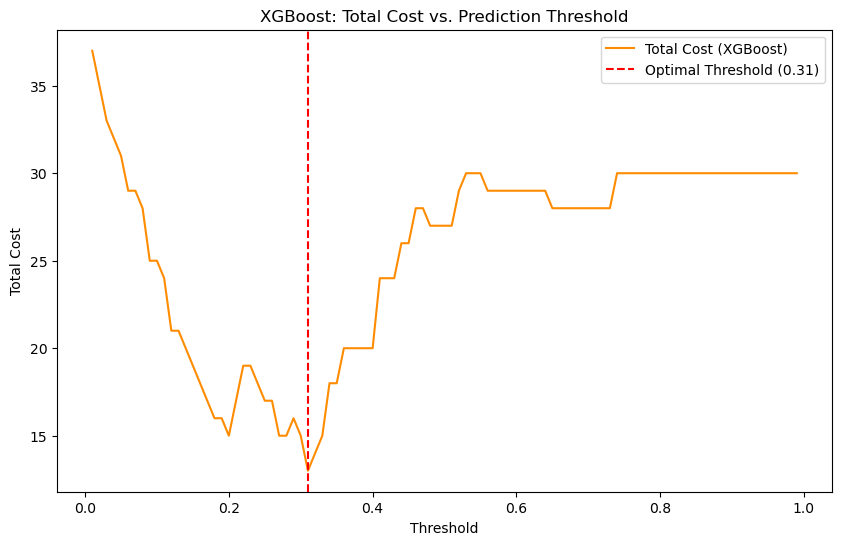

In [64]:
# --- STEP 9: FIND XGBOOST OPTIMAL THRESHOLD BASED ON COST ---
#
# Even though we trained the model to be cost-aware, the 0.5 threshold
# is still not guaranteed to be the *perfect* threshold for our specific cost matrix.
# We can (and should) still perform the threshold-moving step to fine-tune our final decision rule.

costs = {
    'TN_cost': 0,
    'FP_cost': FP_cost,
    'FN_cost': FN_cost,
    'TP_cost': 0
}
print(f"\n--- Finding Optimal Threshold for XGBoost ---")
print(f"Cost of False Positive (FP): {costs['FP_cost']}")
print(f"Cost of False Negative (FN): {costs['FN_cost']}")
print(f"Cost of True Positive (TP): {costs['TP_cost']}")
print(f"Cost of True Negative (TN): {costs['TN_cost']}")

# We will test thresholds from 0.01 to 0.99
thresholds = np.arange(0.01, 1.0, 0.01)
total_costs_xgb = []
num_observations = len(y_test)

for thresh in thresholds:
    predictions_thresh_xgb = (y_pred_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions_thresh_xgb).ravel()
    cost = (tn * costs['TN_cost']) + (fp * costs['FP_cost']) + (fn * costs['FN_cost']) + (tp * costs['TP_cost'])
    total_costs_xgb.append(cost)

optimal_idx_xgb = np.argmin(total_costs_xgb)
optimal_threshold_xgb = thresholds[optimal_idx_xgb]
min_cost_xgb = total_costs_xgb[optimal_idx_xgb]


# >>> TWEAK 4: SHOW COST PER OBSERVATION <<<
#
min_cost_per_obs_xgb = min_cost_xgb / num_observations

print(f"\nXGBoost Optimal Threshold: {optimal_threshold_xgb:.2f}")
print(f"XGBoost Minimum Total Cost: {min_cost_xgb} (for all {num_observations} test observations)")
print(f"XGBoost Minimum Mean Cost Per Observation: {min_cost_per_obs_xgb:.2f}")


# Plot the cost vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, total_costs_xgb, label='Total Cost (XGBoost)', color='darkorange')
plt.axvline(x=optimal_threshold_xgb, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold_xgb:.2f})')
plt.title('XGBoost: Total Cost vs. Prediction Threshold')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.legend()
plt.show()


--- XGBoost Performance at Optimal Threshold (0.31) ---

--- Classification Report (Optimal Threshold) ---
              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86        37
         1.0       0.63      0.80      0.71        15

    accuracy                           0.81        52
   macro avg       0.77      0.81      0.78        52
weighted avg       0.83      0.81      0.81        52



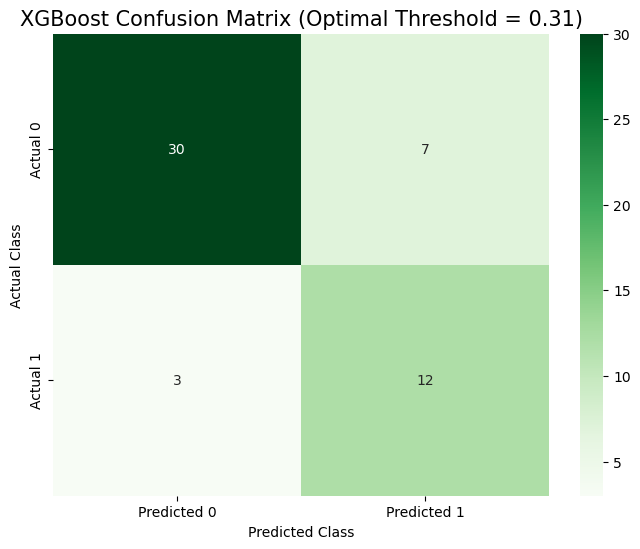

In [65]:
# --- STEP 10: EVALUATE XGBOOST AT OPTIMAL THRESHOLD ---
# Now, let's see the confusion matrix and classification report
# using our new, cost-optimized threshold for XGBoost.

predictions_optimal_xgb = (y_pred_proba >= optimal_threshold_xgb).astype(int)

print(f"\n--- XGBoost Performance at Optimal Threshold ({optimal_threshold_xgb:.2f}) ---")
print("\n--- Classification Report (Optimal Threshold) ---")
print(classification_report(y_test, predictions_optimal_xgb))

# Visualization 3: Confusion Matrix (Optimal Threshold)
cm_optimal_xgb = confusion_matrix(y_test, predictions_optimal_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'XGBoost Confusion Matrix (Optimal Threshold = {optimal_threshold_xgb:.2f})', fontsize=15)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [71]:
best_model_xgb  


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [66]:
# --- FEATURE IMPORTANCE (Top Predictors) ---
import pandas as pd
import numpy as np

# Extract importance values from the trained model
importance_dict = best_model_xgb.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
importance_df = (
pd.DataFrame.from_dict(importance_dict, orient='index', columns=['gain'])
.rename_axis('feature')
.reset_index()
)

# Sort by importance
importance_df = importance_df.sort_values('gain', ascending=False)

# Print top 10
print("\n=== TOP 10 FEATURES (by Gain) ===")
print(importance_df.head(20))


=== TOP 10 FEATURES (by Gain) ===
                                              feature       gain
63                         Popultion (Thousands)_lag4  17.936668
10                                              Total  17.238304
60                                          Mean_lag4  10.806836
16                              Popultion (Thousands)  10.805560
61                                          Mean_lag5   7.003489
17                    Vechiles Miles Travel (Monthly)   2.613226
12                                              Close   2.511990
44                TOTALSALES (Millions of units)_lag6   2.454630
47                                     HCCSDODNS_lag5   2.365238
15                                               Mean   2.352501
39  U.S. Crude Oil and Natural Gas Rotary Rigs in ...   2.000644
75  Texas Natural Gas Price Sold to Electric Power...   1.579708
7                      TOTALSALES (Millions of units)   1.562895
51                                         Close_lag4  

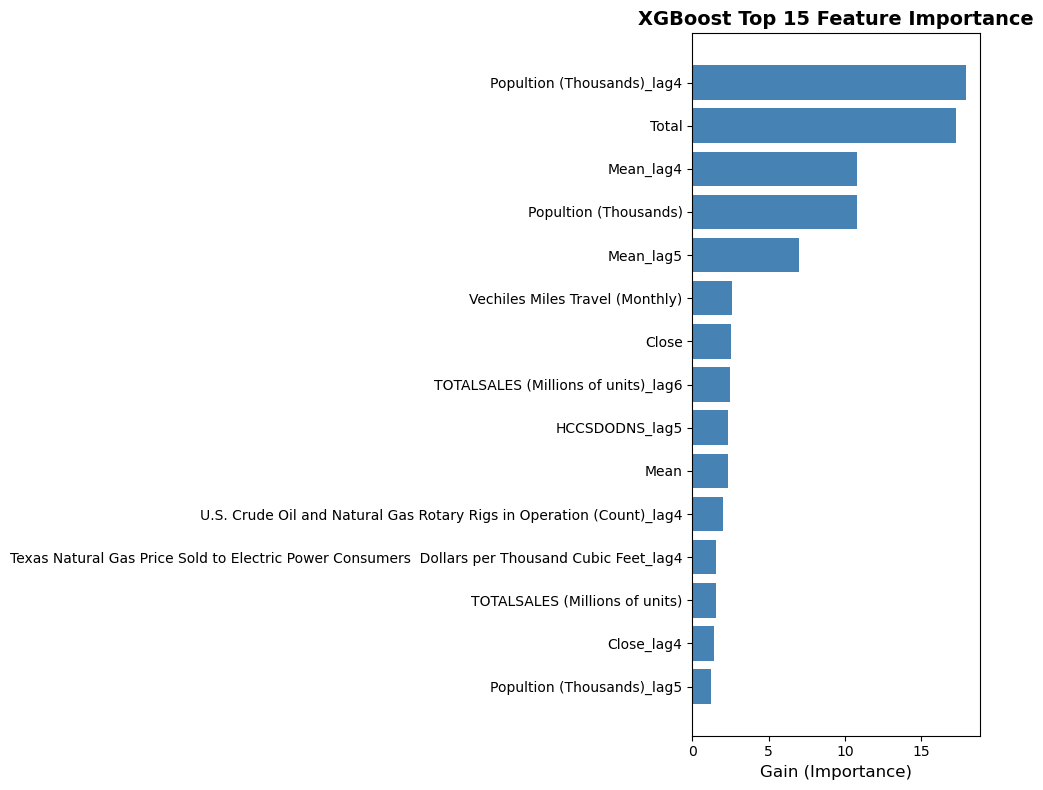

In [67]:
# --- FEATURE IMPORTANCE VISUALIZATION ---
import matplotlib.pyplot as plt

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 15
importance_df_top = importance_df.head(top_n)

ax.barh(range(len(importance_df_top)), importance_df_top['gain'].values, color='steelblue')
ax.set_yticks(range(len(importance_df_top)))
ax.set_yticklabels(importance_df_top['feature'].values)
ax.set_xlabel('Gain (Importance)', fontsize=12)
ax.set_title(f'XGBoost Top {top_n} Feature Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [68]:
X_test_xgb.columns

Index(['S&P 500', 'ICSA', 'Dollars per Barrel',
       'Weekly Europe Brent Spot Price FOB (Dollars per Barrel)',
       'Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)',
       'GDP',
       'U.S. Crude Oil and Natural Gas Rotary Rigs in Operation (Count)',
       'TOTALSALES (Millions of units)', 'PCE(Billions of Dollars)',
       'HCCSDODNS', 'Total', 'Private Industry', 'Close',
       'Median expected home price change',
       'Median one-year ahead expected inflation rate', 'Mean',
       'Popultion (Thousands)', 'Vechiles Miles Travel (Monthly)', 'Anomaly',
       'U.S. Refinery Net Input of Crude Oil (Thousand Barrels)',
       'Texas Natural Gas Price Sold to Electric Power Consumers  Dollars per Thousand Cubic Feet',
       'S&P 500_lag4', 'S&P 500_lag5', 'S&P 500_lag6', 'ICSA_lag4',
       'ICSA_lag5', 'ICSA_lag6', 'Dollars per Barrel_lag4',
       'Dollars per Barrel_lag5', 'Dollars per Barrel_lag6',
       'Weekly Europe Brent Spot Price 

In [69]:
# # --- STEP: CONVERT WEEKLY RESULTS TO MONTHLY METRIC ---

# # 1. Build evaluation dataframe (Actual, Predicted, Date extracted from index)
# df_eval = pd.DataFrame({
#     'Date': X_test_xgb.index,        # <-- Date comes from the index
#     'Actual': y_test.values,
#     'Predicted': predictions_optimal_xgb
# })

# # 2. Convert index-based dates to datetime
# df_eval['Date'] = pd.to_datetime(df_eval['Date'])

# # 3. Convert to monthly periods
# df_eval['Month'] = df_eval['Date'].dt.to_period('M')

# # 4. A month is high-demand if ANY week in that month is high-demand
# monthly_actual = df_eval.groupby('Month')['Actual'].max()
# monthly_pred   = df_eval.groupby('Month')['Predicted'].max()

# # 5. Compute percent of actual high-demand months the model predicted
# actual_high_months  = monthly_actual.sum()
# correct_pred_months = ((monthly_actual == 1) & (monthly_pred == 1)).sum()

# percent_predicted = correct_pred_months / actual_high_months

# print("\n--- Monthly-Level High Demand Detection ---")
# print(f"Actual high-demand months: {actual_high_months}")
# print(f"Correctly predicted high-demand months: {correct_pred_months}")
# print(f"Percent of actual high-demand months predicted: {percent_predicted:.2%}")
